# ASTR 19 Project - Ocean tides at Santa Cruz

Loren Alzona, Janerryll Esclanda, Lingchen Zeng

Importing packages

In [652]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# setting default colors to the graphs
plt.rcParams["text.color"] = "white"
plt.rcParams["axes.labelcolor"] = "white"
plt.rcParams["xtick.color"] = "white"
plt.rcParams["ytick.color"] = "white"
plt.rcParams["axes.edgecolor"] = "white"
plt.rcParams["legend.edgecolor"] = "black"
plt.rcParams["legend.facecolor"] = "none"
plt.rcParams["legend.labelcolor"] = "black"

Turn the raw data into usable array,

In [653]:
raw_data_path = "ASTR19_F25_group_project_data.txt"

usable_data = np.genfromtxt(
    raw_data_path,
    comments="#",
    dtype=[("day", int), ("time_str", "U8"), ("height_ft", float)],
    autostrip=True,
)

Extract usable information like time of the day and height of the tide, in consideration of the fact that the time is in hour:minutes form

In [654]:
parts = np.char.partition(usable_data["time_str"], ":")
hour = parts[:, 0].astype(int)
minute = parts[:, 2].astype(int)

#T+ time in minutes if needs to be used in the future
t_plus_minutes = ((24 * (usable_data["day"]-1) + hour) * 60) + minute
#T+ time in hours
t_plus_hours = t_plus_minutes / 60
y_axis = usable_data["height_ft"].astype(float)

Just making sure everything is running just fine

In [655]:
print(f"Loaded {t_plus_hours.size} rows from {raw_data_path}")
for i in range(usable_data.size):
   print(f"day={usable_data['day'][i]} "
         f"time={usable_data['time_str'][i]} "
         f"t_hours={t_plus_hours[i]} "
         f"t_minutes={t_plus_minutes[i]} "
         f"height_ft={y_axis[i]}")

Loaded 82 rows from ASTR19_F25_group_project_data.txt
day=1 time=8:07 t_hours=8.116666666666667 t_minutes=487 height_ft=6.57
day=1 time=15:37 t_hours=15.616666666666667 t_minutes=937 height_ft=-0.39
day=2 time=8:55 t_hours=32.916666666666664 t_minutes=1975 height_ft=5.38
day=2 time=16:25 t_hours=40.416666666666664 t_minutes=2425 height_ft=-1.74
day=3 time=9:45 t_hours=57.75 t_minutes=3465 height_ft=5.26
day=3 time=17:14 t_hours=65.23333333333333 t_minutes=3914 height_ft=-1.36
day=4 time=10:35 t_hours=82.58333333333333 t_minutes=4955 height_ft=4.13
day=4 time=18:00 t_hours=90.0 t_minutes=5400 height_ft=-1.15
day=5 time=11:28 t_hours=107.46666666666667 t_minutes=6448 height_ft=3.48
day=5 time=18:46 t_hours=114.76666666666667 t_minutes=6886 height_ft=-1.61
day=6 time=12:22 t_hours=132.36666666666667 t_minutes=7942 height_ft=2.62
day=6 time=19:31 t_hours=139.51666666666668 t_minutes=8371 height_ft=0.05
day=7 time=13:24 t_hours=157.4 t_minutes=9444 height_ft=1.83
day=7 time=20:16 t_hours=16

Define an oscillation function that reflect the tide trend (both in a 12hour cycle and 24 hour cycle)

In [656]:
# Known the line should goes just like a sine function
# Known that we need to describe the intra- and inter-day variations, that means the sum of two periodic sine functions

# Set up for adjusting amplitude and phase (in minutes)
def tide_model(t, A1, phase1, A2, phase2, offset):
    intra_time = 12.0 *60
    inter_time = 24.0 *60
    return (A1*np.sin(2*np.pi * t / intra_time + phase1) +
            A2*np.sin(2*np.pi * t / inter_time + phase2) +
            offset)

Curve fitting

In [657]:
# given 0.25
uncertainty = 0.25
# In its documentation, the sigma modifier of the curve fit must match the length and format of ydata
sigma = np.full_like(y_axis, uncertainty, dtype=float)


popt, pcov = curve_fit(
    f = tide_model,
    xdata = t_plus_minutes,
    ydata = y_axis,
    sigma = sigma,
)

print("Fit params:", popt)

y_fit = tide_model(t_plus_minutes, *popt)

Fit params: [9.24296202e-01 9.08782324e+00 2.83055736e+00 3.41780080e-03
 2.58038746e+00]


Tide graph

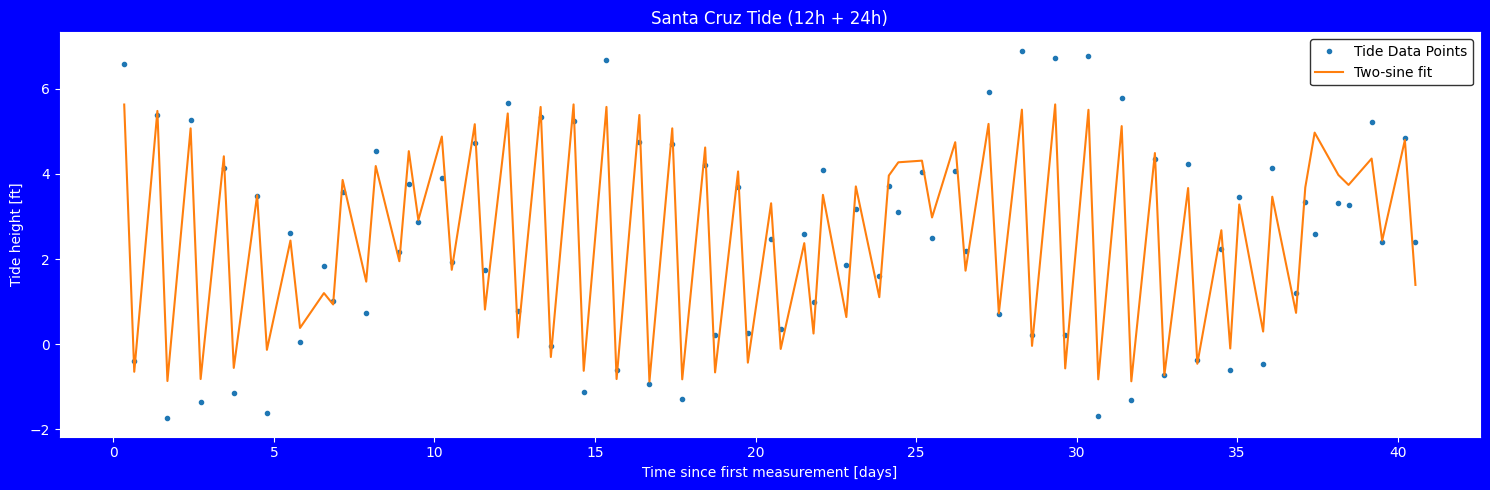

In [658]:
t_plot_days = t_plus_hours / 24.0

plt.figure(figsize=(15,5),facecolor="blue")
plt.plot(t_plot_days, y_axis, ".", label="Tide Data Points")
plt.plot(t_plot_days, y_fit, "-", label="Two-sine fit")

plt.xlabel("Time since first measurement [days]")
plt.ylabel("Tide height [ft]")
plt.title("Santa Cruz Tide (12h + 24h)")
plt.legend()
plt.tight_layout()
plt.savefig("Santa_Cruz_Tide (12h + 24h).pdf") # save as pdf
plt.show()

Calculating residual

In [659]:
resid = y_axis - y_fit
std_resid = np.std(resid, ddof=1)

Residual graph

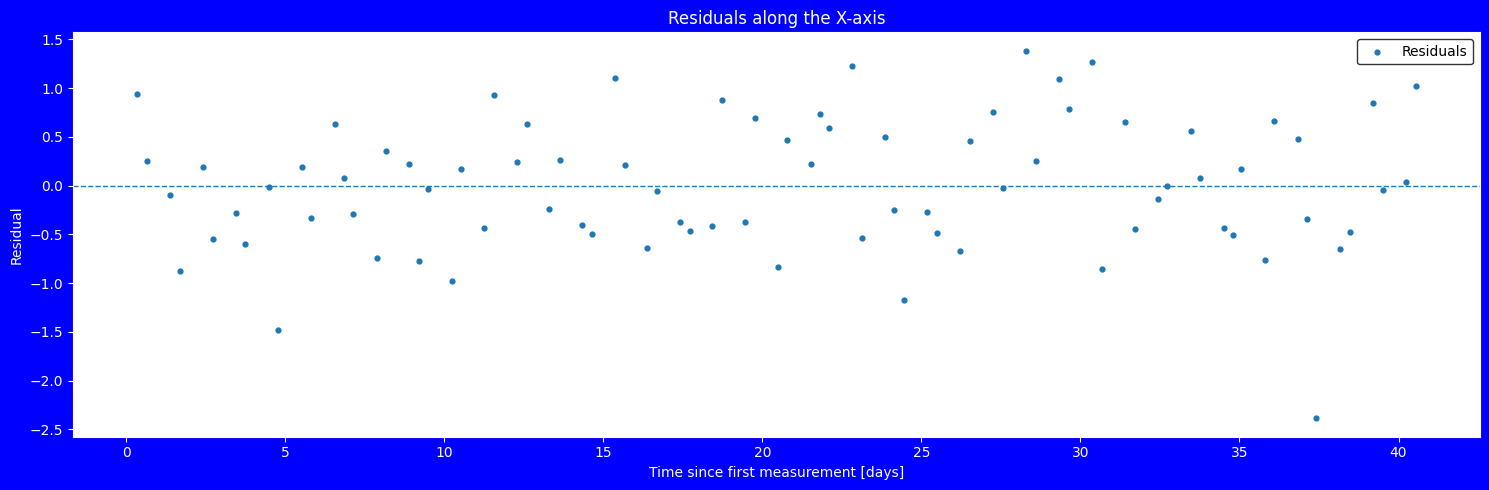

In [660]:
plt.figure(figsize=(15,5),facecolor="blue")
plt.axhline(0, ls="--", lw=1)
plt.scatter(t_plot_days, resid, s=12, label="Residuals")
plt.xlabel("Time since first measurement [days]")
plt.ylabel("Residual")
plt.title("Residuals along the X-axis")
plt.legend()
plt.tight_layout()
plt.savefig("Residuals.pdf") # save as pdf
plt.show()

Residual histogram

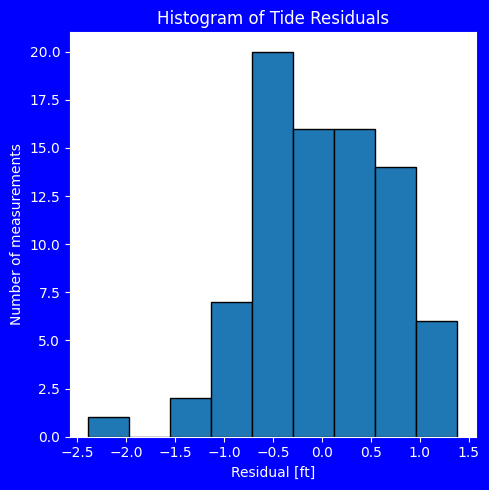

Residual standard deviation: 0.6775969614030066
Scatter in the data larger than the assume value of 0.25


In [661]:
plt.figure(figsize=(5,5), facecolor="blue")

# "reasonable" number of bins = sqrt of n
n_bins = int(np.sqrt(len(resid)))

plt.hist(
    resid,
    bins=n_bins,
    edgecolor="black",
    histtype="bar"
)

plt.xlabel("Residual [ft]")
plt.ylabel("Number of measurements")
plt.title("Histogram of Tide Residuals")
plt.tight_layout()
plt.savefig("Residuals_histogram.pdf")
plt.show()

print(f"Residual standard deviation: {std_resid}")
if std_resid > uncertainty:
    print(f"Scatter in the data larger than the assume value of {uncertainty}")

Estimate intrinsic scatter

In [662]:
intrinsic = np.sqrt(max(0.0, std_resid**2 - uncertainty**2))
print(f"Estimated intrinsic scatter: {intrinsic}")

Estimated intrinsic scatter: 0.6297917450257566


Tsunami impact study